### Imports

In [1]:
import sys
sys.path.insert(0, 'D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\Classes')

import warnings
warnings.filterwarnings('ignore')

from models import ClassificationModel, EmbeddingsModel, SiameseModel
from trainer import SiameseTrainerCombinationDataset, all_subjects_intense

import torch
import json
import numpy as np
import csv
from tqdm import tqdm


### Set Hyperparameters

In [2]:
x=0
subjects_test = all_subjects_intense[int(x*2.4):int((x+1)*2.4)]

In [3]:
#subjects_test = all_subjects_intense[:1]
subjects_train = [sub for sub in all_subjects_intense if sub not in subjects_test]

In [4]:
trainer_hyperparameter = {
    "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\INTENSE\\normalized_subjects_no_outliner.pkl",
    "subjects_train": subjects_train,
    "subjects_test": subjects_test,
    "wandb": False,
    "log": True,
    "learning_rate": 0.01,
    "batch_size": 256,
    "batch_size_test": 256,
    "dataset_ignore_subject_train": True,
    "dataset_ignore_subject_test": False,
    "decision_function": 0,
    "filter": [],
    "weight_decay": 0.0015,
    "lr_steps": 10,
    "adam": True,
    "number_steps": None,
    "number_steps_testing": None,
    "number_steps_histogramm": None
}

model_embedding_hyperparameter = {
        "sigmoid": False,
        "dropout": 0.35,
        "layers": [207, 512, 64]
}

model_classifier_hyperparameter = {
    "dropout": 0.35,
    "layers": [64, 32]
}

### Init models

In [11]:
classifier_model = ClassificationModel(model_classifier_hyperparameter)
embedding_model = EmbeddingsModel(model_embedding_hyperparameter)

siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])

#_ = siamese_model.load_state_dict(torch.load("D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\TransferLearning\pretrained_models\model_all.pth"))

In [12]:
trainer = SiameseTrainerCombinationDataset(trainer_hyperparameter, siamese_model, device="cuda:0")

### start training

In [13]:
subjects_test

['1', '10']

In [14]:
trainer.trainloop(40)

epoch: 1 | train_acc: 0.5044 | test_acc: 0.5354
epoch: 2 | train_acc: 0.5078 | test_acc: 0.4747
epoch: 3 | train_acc: 0.5016 | test_acc: 0.4798
epoch: 4 | train_acc: 0.5805 | test_acc: 0.6263
epoch: 5 | train_acc: 0.6704 | test_acc: 0.8788
epoch: 6 | train_acc: 0.7382 | test_acc: 0.7576
epoch: 7 | train_acc: 0.7845 | test_acc: 0.9091
epoch: 8 | train_acc: 0.8059 | test_acc: 0.9141
epoch: 9 | train_acc: 0.8541 | test_acc: 0.8737
epoch: 10 | train_acc: 0.879 | test_acc: 0.9091
epoch: 11 | train_acc: 0.924 | test_acc: 0.9091
epoch: 12 | train_acc: 0.9553 | test_acc: 0.9141
epoch: 13 | train_acc: 0.9689 | test_acc: 0.904
epoch: 14 | train_acc: 0.9804 | test_acc: 0.9141
epoch: 15 | train_acc: 0.9844 | test_acc: 0.9141
epoch: 16 | train_acc: 0.9882 | test_acc: 0.904
epoch: 17 | train_acc: 0.9901 | test_acc: 0.9141
epoch: 18 | train_acc: 0.9885 | test_acc: 0.904
epoch: 19 | train_acc: 0.9856 | test_acc: 0.8384
epoch: 20 | train_acc: 0.9829 | test_acc: 0.9141
epoch: 21 | train_acc: 0.9925 | te

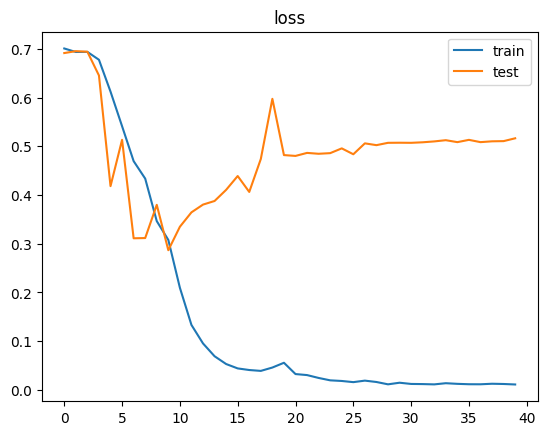

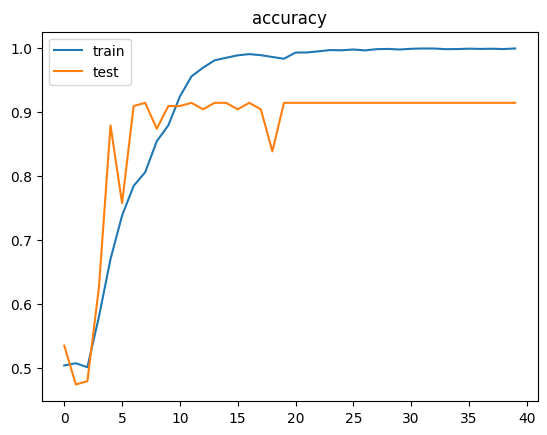

In [16]:
trainer.plot_history()

## LOOP

In [2]:
saving_path = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\TransferLearning\\results-LOSO\\intense_model_tonic_electric.csv"
model_path = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\TransferLearning\pretrained_models\model_tonic_electric.pth"

### LOSO

In [ ]:
for subj in tqdm(all_subjects_intense):
    subjects_test = [subj]
    subjects_train = [sub for sub in all_subjects_intense if sub not in subjects_test]

    trainer_hyperparameter = {
        "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\INTENSE\\normalized_subjects_no_outliner.pkl",
        "subjects_train": subjects_train,
        "subjects_test": subjects_test,
        "wandb": False,
        "log": True,
        "learning_rate": 0.01,
        "batch_size": 256,
        "batch_size_test": 256,
        "freeze_embed": False,
        "dataset_ignore_subject_train": True,
        "dataset_ignore_subject_test": False,
        "decision_function": 0,
        "filter": [],
        "weight_decay": 0.0015,
        "lr_steps": 10,
        "adam": True,
        "number_steps": None,
        "number_steps_testing": None,
        "number_steps_histogramm": None
    }

    model_embedding_hyperparameter = {
            "sigmoid": False,
            "dropout": 0.35,
            "layers": [207, 512, 64]
    }

    model_classifier_hyperparameter = {
        "dropout": 0.35,
        "layers": [64, 32],
        "multiclass": False
    }

    classifier_model = ClassificationModel(model_classifier_hyperparameter)
    embedding_model = EmbeddingsModel(model_embedding_hyperparameter)

    siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])
    _ = siamese_model.load_state_dict(torch.load(model_path))

    trainer = SiameseTrainerCombinationDataset(trainer_hyperparameter, siamese_model, device="cuda:0")

    trainer.trainloop(40)

    best_epoch = max(trainer.history, key=lambda x:x['test_acc'])["epoch"]
    cm = trainer.history_cm[best_epoch-1]["cm"]

    acc = trainer.history[best_epoch-1]["test_acc"]
    results = trainer.calculate_f_scores(cm)
    recall = results["recall"]
    precision = results["recall"]
    f1 = results["recall"]
    s = np.sum(cm, axis=1)
    cm = cm.astype('float64')
    cm[0] = cm[0]/s[0]
    cm[1] = cm[1]/s[1]
    tn = cm[0,0]
    fn = cm[0,1]
    fp = cm[1,0]
    tp = cm[1,1]

    with open(saving_path, mode='a') as result_file:
            results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            results_writer.writerow([subj, acc*100, recall, precision, f1, tn, fn, fp, tp, best_epoch])

### 10 fold

In [ ]:
for x in tqdm(range(10)):
    subjects_test = all_subjects_intense[int(x*2.4):int((x+1)*2.4)]
    subjects_train = [sub for sub in all_subjects_intense if sub not in subjects_test]
    
    trainer_hyperparameter = {
        "path": "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\INTENSE\\normalized_subjects_no_outliner.pkl",
        "subjects_train": subjects_train,
        "subjects_test": subjects_test,
        "wandb": False,
        "log": True,
        "learning_rate": 0.01,
        "batch_size": 256,
        "batch_size_test": 256,
        "dataset_ignore_subject_train": True,
        "dataset_ignore_subject_test": False,
        "decision_function": 0,
        "filter": [],
        "weight_decay": 0.0015,
        "lr_steps": 10,
        "adam": True,
        "number_steps": None,
        "number_steps_testing": None,
        "number_steps_histogramm": None
    }

    model_embedding_hyperparameter = {
            "sigmoid": False,
            "dropout": 0.35,
            "layers": [207, 512, 64]
    }

    model_classifier_hyperparameter = {
        "dropout": 0.35,
        "layers": [64, 32],
        "multiclass": False
    }

    classifier_model = ClassificationModel(model_classifier_hyperparameter)
    embedding_model = EmbeddingsModel(model_embedding_hyperparameter)

    siamese_model = SiameseModel(embedding_model, classifier_model, decision_function=trainer_hyperparameter["decision_function"])
    _ = siamese_model.load_state_dict(torch.load(model_path))

    trainer = SiameseTrainerCombinationDataset(trainer_hyperparameter, siamese_model, device="cuda:0")

    trainer.trainloop(40)

    best_epoch = max(trainer.history, key=lambda x:x['test_acc'])["epoch"]
    cm = trainer.history_cm[best_epoch-1]["cm"]


    acc = trainer.history[best_epoch-1]["test_acc"]
    results = trainer.calculate_f_scores(cm)
    recall = results["recall"]
    precision = results["recall"]
    f1 = results["recall"]
    s = np.sum(cm, axis=1)
    cm = cm.astype('float64')
    cm[0] = cm[0]/s[0]
    cm[1] = cm[1]/s[1]
    tn = cm[0,0]
    fn = cm[0,1]
    fp = cm[1,0]
    tp = cm[1,1]

    with open(saving_path, mode='a') as result_file:
            results_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            results_writer.writerow(["split_"+str(x), acc*100, recall, precision, f1, tn, fn,fp, tp, best_epoch])